In [134]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import os
from os.path import abspath, isfile, join
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd

## Load data

In [86]:
def rgba2rgb(image):
    if image.shape[2] == 3:
        return 1 - image
    alpha = image[:, :, 3]
    rgb = image[:, :, :3]
    black_spot = alpha == 0.0
    rgb += black_spot.reshape(rgb.shape[0], rgb.shape[1], 1)
    return rgb

def read_images_content(*path):
    filepath = abspath(join(*path))
    files = [f for f in listdir(filepath) if isfile(join(filepath, f))]
    images = [rgba2rgb(plt.imread(join(filepath, f))) for f in files]
    return images

IMG_SIZE = 64

transform = transforms.Compose([transforms.ToPILImage(),
                                # transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                # transforms.Grayscale(),
                                transforms.ToTensor(), 
                                # transforms.Normalize((0.5,), (0.5,))
                               ])

class PokemonDataset(Dataset):
    def __init__(self, *data_file, transform=None):
        self.data = read_images_content(*data_file)
        self.transform = transform

    def __getitem__(self, index: int) -> torch.Tensor:
        sample = self.data[index]
        if self.transform:
            sample = self.transform(np.uint8(sample * 255))
        return sample.squeeze()

    def __len__(self):
        return len(self.data)
    
images_data = PokemonDataset("pokemon-images-and-types", "images", "images", transform=transform)


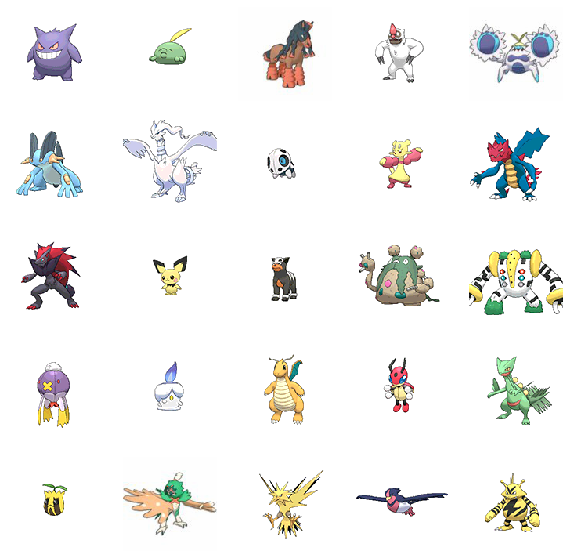

In [112]:
ind = np.random.randint(1, high=len(images_data), size=25)
pokemons = [images_data[i] for i in ind]
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(np.transpose(pokemons[i*5 + j], (1, 2, 0)), cmap='gray')
        # ax[i,j].imshow(pokemons[i*5 + j], cmap='gray')
        ax[i,j].axis('off')

In [114]:
def get_data():
    transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, ), (0.5, ))])
    return datasets.MNIST(root='./', transform=transform, download=True)

batch_size = 100
data = get_data()

0it [00:00, ?it/s]

100%|█████████▉| 9912320/9912422 [01:36<00:00, 73995.05it/s] 

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



0it [00:00, ?it/s]


 28%|██▊       | 8192/28881 [00:00<00:00, 35628.36it/s]
32768it [00:00, 55980.09it/s]                           

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



 96%|█████████▌| 1581056/1648877 [00:12<00:00, 92749.78it/s] 
9920512it [01:50, 73995.05it/s]                             ]
 99%|█████████▉| 1638400/1648877 [00:12<00:00, 82350.10it/s] 

0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




8192it [00:00, 34699.62it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [115]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(dataloader)

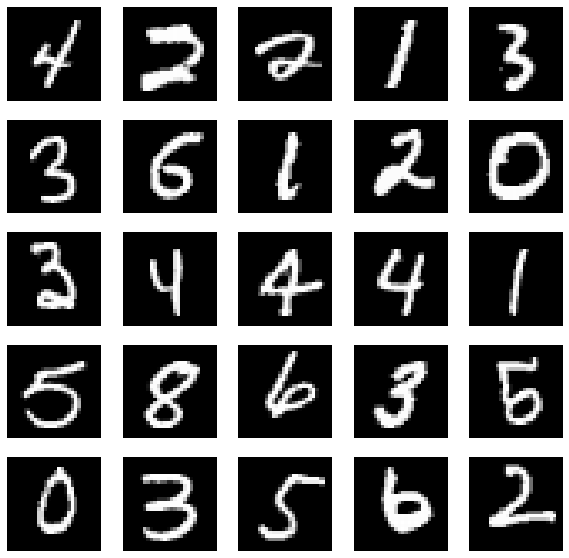


1654784it [00:32, 82350.10it/s]                             

In [116]:
IMG_SIZE = 28
ind = np.random.randint(1, high=len(data), size=25)
digits = [data[i] for i in ind]
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(digits[i*5 + j][0].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        ax[i,j].axis('off')

In [257]:
def hidden(in_features, out_features, negative_slope=0.2, dropout_rate=0.3, dropout=True):
    h = nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.LeakyReLU(negative_slope=negative_slope))
    if dropout:
        h.add_module('dropout', nn.Dropout(dropout_rate))
    return h

def output_layer(in_features, out_features, activation_func):
    return nn.Sequential(
        nn.Linear(in_features=in_features, out_features=out_features),
        activation_func)

class Discriminator(nn.Module):
    def __init__(self, n_features=784):
        super().__init__()
        self.hidden_layers = nn.Sequential(
            hidden(n_features, 1024),
            hidden(1024, 512),
            hidden(512, 256))
        self.output_layer = output_layer(256, 1, nn.Sigmoid())

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x
    
class Generator(nn.Module):
    def __init__(self, n_ditsributions=30, n_features=100, n_output=784):
        super().__init__()
        mu = 2 * torch.rand(n_ditsributions) - 1
        mu.requires_grad = True
        self.mu = nn.Parameter(mu)
        sigma = 0.2 * torch.ones(n_ditsributions)
        sigma.requires_grad = True
        self.sigma = nn.Parameter(sigma)
        self.hidden_layers = nn.Sequential(
            hidden(n_features, 256, dropout=False),
            hidden(256, 512, dropout=False),
            hidden(512, 1024, dropout=False))
        self.output_layer = output_layer(1024, n_output, nn.Tanh())

    def forward(self, x):
        idx = torch.randint(0, self.mu.size(0), x.size())
        x = x * self.sigma[idx] + self.mu[idx]
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x
    
def noise(size, n_features=100):
    eps = torch.normal(0, 1, (size, n_features))
    # eps = torch.randn(size, n_features)
    if torch.cuda.is_available():
        return eps.cuda()
    return eps

def ones_tensor(size):
    t = torch.ones(size, 1)
    if torch.cuda.is_available():
        return t.cuda()
    return t

def zeros_tensor(size):
    t = torch.zeros(size, 1)
    if torch.cuda.is_available():
        return t.cuda()
    return t

In [258]:
discriminator = Discriminator()
generator = Generator()

learning_rate = 0.0002
d_optim = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optim = optim.Adam(generator.parameters(), lr=learning_rate * 10)

loss_function = nn.BCELoss()

def discriminator_step(optimizer, loss_function, true_data, fake_data):
    optimizer.zero_grad()
    output_true = discriminator(true_data)
    loss_true = loss_function(output_true, ones_tensor(true_data.size(0)))
    loss_true.backward()

    output_fake = discriminator(fake_data)
    loss_fake = loss_function(output_fake, zeros_tensor(fake_data.size(0)))
    loss_fake.backward()

    optimizer.step()
    return loss_true + loss_fake

def generator_step(optimizer, loss_function, fake_data):
    optimizer.zero_grad()
    output = discriminator(fake_data)
    loss = loss_function(output, ones_tensor(output.size(0)))
    # loss.backward()
    (loss + 0.01 * torch.mean(torch.pow(1-generator.sigma, 2))).backward()
    optimizer.step()
    return loss

In [214]:
def images_to_vectors(images, n_features=784):
    return images.view(images.size(0), n_features)


In [259]:
def train_gan(loss_function, num_epochs=100):
    d_losses = []
    g_losses = []
    for epoch in range(num_epochs):
        print(f'\r epoch: [{epoch+1}/{num_epochs}]', end='')
        for true_batch,_ in dataloader:
            true_data = images_to_vectors(true_batch)
            if torch.cuda.is_available():
                true_data = true_data.cuda()
            fake_data = generator(noise(true_data.size(0))).detach()
            discriminator_loss = discriminator_step(d_optim, loss_function, true_data, fake_data)
            fake_data = generator(noise(true_batch.size(0)))
            generator_loss = generator_step(g_optim, loss_function, fake_data)
            print(f'\r epoch: [{epoch+1}/{num_epochs}], discriminator: {discriminator_loss.data}, generator: {generator_loss.data}', end='')
        d_losses.append(float(discriminator_loss.data.cpu()))
        g_losses.append(float(generator_loss.data.cpu()))
    return d_losses, g_losses

In [260]:
num_epochs = 100

d_losses, g_losses = train_gan(loss_function, num_epochs)


 epoch: [4/100], discriminator: 5.403670729720034e-05, generator: 17.9349250793457037

KeyboardInterrupt: 

In [221]:
generator.mu


Parameter containing:
tensor([-0.0355, -0.6806,  0.4842, -0.4248, -0.4293, -0.4142, -0.4273,  0.6418,
        -0.0374,  0.4712, -0.0338, -0.0337,  0.4422,  0.5134, -0.0336, -0.0357,
        -0.4127, -0.0341, -0.4851,  0.4270, -0.3951, -0.4130, -0.6258, -0.0343,
        -0.0330, -0.0337, -0.0356,  0.4183, -0.0340, -0.0351],
       requires_grad=True)

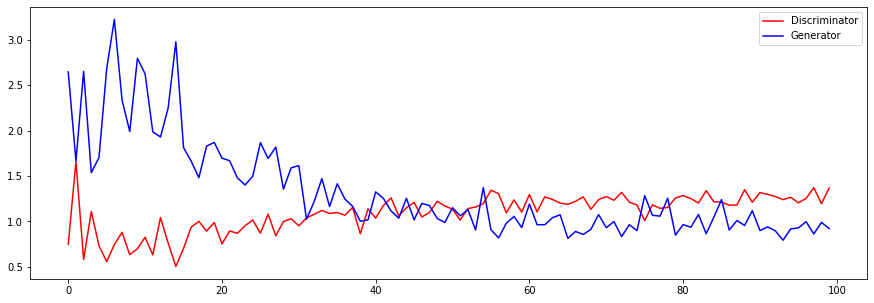

In [135]:
dat = pd.DataFrame({'d':d_losses, 'g':g_losses})
dat['epoch'] = np.arange(num_epochs)

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(dat['epoch'], dat['d'], color='red', label='Discriminator')
ax.plot(dat['epoch'], dat['g'], color='blue', label='Generator')
ax.legend();

In [136]:
def image_grid_figure(sample, cols=15, rows=15, width=28, height=28, figsize=(15, 15), tags=None):
    fig, ax = plt.subplots(cols, rows, sharex='col', sharey='row', figsize=figsize)
    for i in range(cols):
        for j in range(rows):
            ax[i, j].imshow(sample[i * cols + j].reshape(width, height), cmap='gray')
            if tags is not None:
                ax[i, j].text(width // 2, -1.5, str(tags[i * cols + j]), ha='center')
            ax[i, j].axis('off')
    return fig

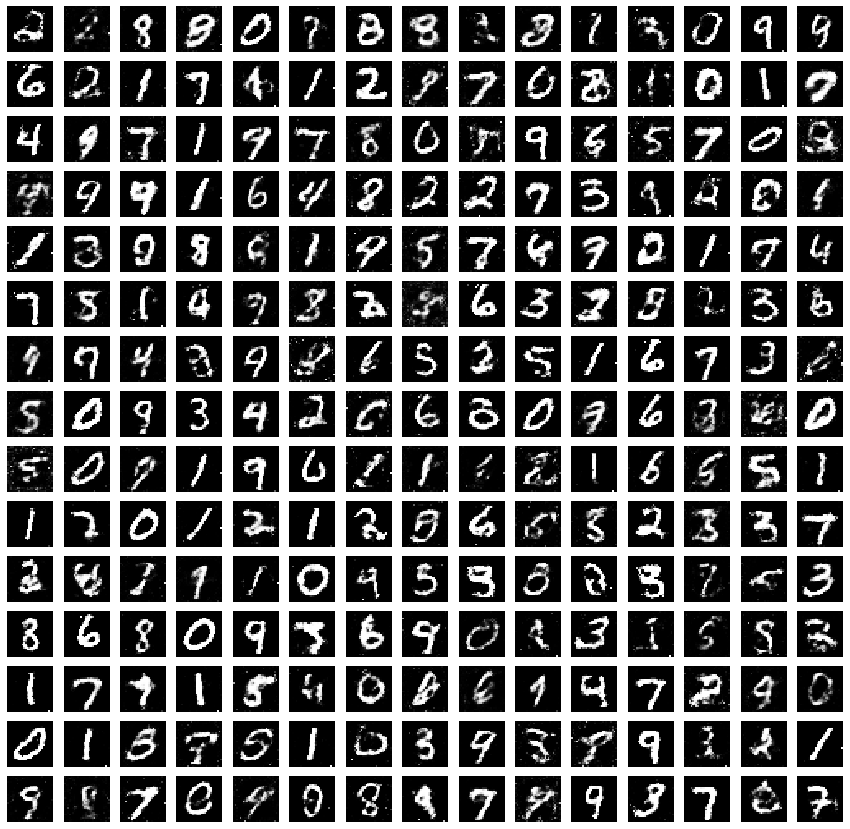

In [137]:
fake_digits = generator(noise(225)).data.cpu().numpy()
fig_grid = image_grid_figure(fake_digits)

In [234]:
class RandMull(nn.Module):
    def __init__(self):
        super(RandMull, self).__init__()
        self.p = nn.Parameter(torch.tensor([1.0, 2.0, 3.0], requires_grad=True))
        
    def forward(self, x):
        idx = torch.randint(0, self.p.size(0), x.size())
        print(self.p[idx])
        return x * self.p[idx]
               
m = RandMull()
opt = optim.Adam(m.parameters())
print(m.p)
a = torch.ones(10, 2)
loss = torch.sum(m(a)) + torch.mean(m.p)
loss.backward()
opt.step()
print(m.p)

Parameter containing:
tensor([1., 2., 3.], requires_grad=True)
tensor([[3., 2.],
        [1., 3.],
        [3., 1.],
        [2., 2.],
        [3., 3.],
        [2., 3.],
        [3., 3.],
        [2., 2.],
        [2., 3.],
        [3., 3.]], grad_fn=<IndexBackward>)
Parameter containing:
tensor([0.9990, 1.9990, 2.9990], requires_grad=True)


In [209]:
a  = torch.Tensor([0,1,2,3,4,5])
0.1 * torch.mean(torch.pow(1-a, 2))

tensor(0.5167)

In [231]:
torch.normal(0, 1, (10, 2)).numel()

20